In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# Code from TA, see Zulip

#def process_chunk(chunk):
#        print(f'Processing chunk with {len(chunk)} rows')
#        print(chunk.columns)

#df_reader = pd.read_json('data/quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=1000000)
#for chunk in df_reader:
#    process_chunk(chunk)

In [3]:
# Import data

# Dataset: download at https://www.kaggle.com/headsortails/us-natural-disaster-declarations
# nd = natural disaters
nd_frame = pd.read_csv('data/us_disaster_declarations.csv')
print(nd_frame.dtypes)

fema_declaration_string       object
disaster_number                int64
state                         object
declaration_type              object
declaration_date              object
fy_declared                    int64
incident_type                 object
declaration_title             object
ih_program_declared            int64
ia_program_declared            int64
pa_program_declared            int64
hm_program_declared            int64
incident_begin_date           object
incident_end_date             object
disaster_closeout_date        object
fips                           int64
place_code                     int64
designated_area               object
declaration_request_number     int64
hash                          object
last_refresh                  object
id                            object
dtype: object


Text(0, 0.5, 'Frequency')

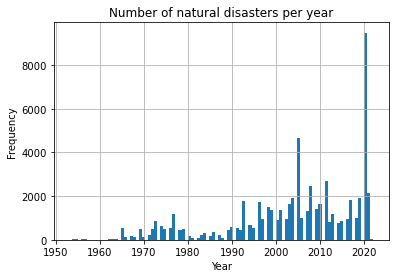

In [4]:
# Natural disasters per year
nd_frame['fy_declared'].hist(bins=100)
plt.title("Number of natural disasters per year")
plt.xlabel("Year")
plt.ylabel("Frequency")

# 2020 because of Covid-19 ? -> TODO: remove rows after April 2020 (don't have quotes for it) 
# Remove "Biological" disasters ????

In [5]:
# get data rows from 2015 to 2020 and drop irrelevant rows
nd_frame.drop(nd_frame[nd_frame['fy_declared'] < 2015].index, inplace = True)
nd_frame.drop(nd_frame[nd_frame['fy_declared'] > 2020].index, inplace = True)

nd_frame.drop(nd_frame[nd_frame.incident_type == "Other"].index, inplace = True)
print(nd_frame.head().iloc[:, :7])

      fema_declaration_string  disaster_number state declaration_type  \
44317              DR-4197-NM             4197    NM               DR   
44318              DR-4197-NM             4197    NM               DR   
44319              DR-4197-NM             4197    NM               DR   
44320              DR-4197-NM             4197    NM               DR   
44321              DR-4197-NM             4197    NM               DR   

           declaration_date  fy_declared    incident_type  
44317  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44318  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44319  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44320  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44321  2014-10-06T19:20:00Z         2015  Severe Storm(s)  


In [6]:
# Not all are "natural" disasters
nd_types = nd_frame.incident_type.unique()
print(nd_types)

['Severe Storm(s)' 'Fire' 'Volcano' 'Flood' 'Snow' 'Tornado'
 'Severe Ice Storm' 'Typhoon' 'Coastal Storm' 'Toxic Substances'
 'Hurricane' 'Mud/Landslide' 'Dam/Levee Break' 'Earthquake' 'Biological']


In [7]:
# CAN DO MORE BASIC STATISTICS 
print(f"Number of natural disasters from 2015 to 2020: %d" % len(nd_frame.index))

Number of natural disasters from 2015 to 2020: 16068


In [8]:
#TODO: Data handling and analysis
#print(nd_frame['incident_type'].value_counts())

<AxesSubplot:title={'center':'Occurence of disasters'}>

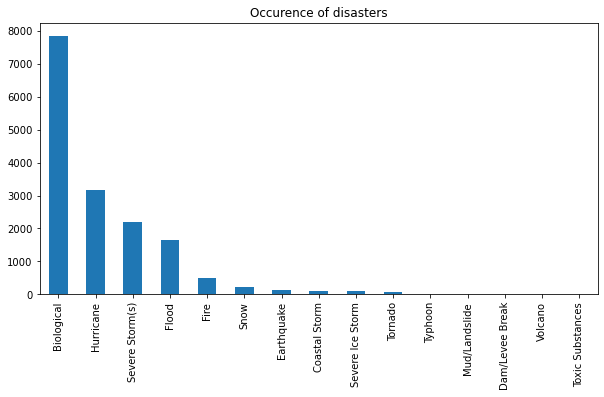

In [9]:
# Occurence of different disasters
nd_frame['incident_type'].value_counts().plot(kind='bar', figsize=(10, 5), title="Occurence of disasters")

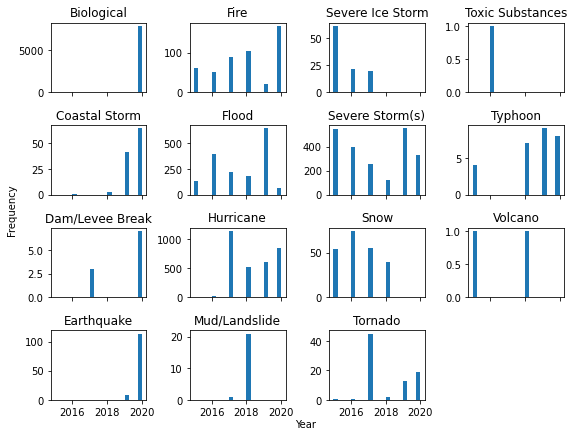

In [10]:
stats_by_type = nd_frame.groupby('incident_type').apply(lambda x: pd.Series({
        'fy_declared': x['fy_declared'].values
    }))

fig, ax = plt.subplots(4, 4, figsize= (8,6), sharey = False, sharex = True)

for i in range(15):
    sbplt = ax[i%4, math.floor(i/4)]
    sbplt.hist(stats_by_type.iloc[i].values, range=[2015,2020], bins = 20)
    sbplt.set_title(stats_by_type.index[i])
    
fig.tight_layout()

fig.text(0.5,0, "Year")
fig.text(0,0.45, "Frequency", rotation = 90)
fig.delaxes(ax[3][3])

# !!!!!! y-axis not the same (intended)